# Pune House Price Prediction 📶💸💸🏚️🏗️🏠💸💸📶

## Data Pre-processing and Feature Engineering

### Feature engineering Purpose: 
- To clean and pre-process given data features by defining set of functions. 
- Identify different ways to represent given features into numerical/ model interpretable encodings.
- Extract and Engineer new meaningful features, if any.
- Prepare clean Training and Testing data for model life-cycle.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json
import math
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder

In [2]:
raw_data = pd.read_excel("../data/raw_data/Pune_Real_Estate_Data.xlsx")

In [3]:
## Set random seed for any random operations hence-forth
random_seed = 42

### Perform initial cleaning as explained in EDA

In [4]:
clean_df = raw_data.copy().drop(["Sr. No.", "Location", "Description"], axis = 1)
clean_df = clean_df.rename(columns={"Sub-Area": "Location", "Propert Type" : "Type", "Property Area in Sq. Ft." : "Area_sqft", "Price in lakhs" : "Price_Lakhs", "Price in Millions" : "Price_Mil",
                                    "Company Name" : "Developer", "TownShip Name/ Society Name" : "Name", "Total TownShip Area in Acres" : "Area_township", "ClubHouse" : "hasClubHouse",
                                    "School / University in Township ": "hasEduFacility", "Hospital in TownShip": "hasHospital", "Mall in TownShip" : "hasMall", "Park / Jogging track" : "hasParkOrJogTrack",
                                    "Swimming Pool" : "hasPool", "Gym" : "hasGym" })
clean_df["Price_Mil"] = clean_df["Price_Mil"].apply(lambda x:round(float(x), 4) if str(x).replace(".", "", 1).isdigit() else np.NAN).astype("float64")
clean_df["Price_Mil"] = clean_df["Price_Mil"].replace([np.NAN], 9.5)
clean_df["Price_Mil"] = clean_df["Price_Mil"].replace([92.300, 93.000], [9.230, 9.300])

### Fix Property area in square footage

obtain the float value either by converting from string or by generating a mean of the range

In [5]:
#Consider mean area in case of a range
def get_area(area):
    if str(area).isdigit():
        return float(area)
    else:
        s = [float(s) for s in re.findall(r'-?\d+\.?\d*', str(area))]
        if len(s) == 0:
            return np.NAN
        else:
            return np.mean(s)

clean_df["Area_sqft"] = clean_df["Area_sqft"].apply(lambda x:get_area(x))
clean_df["Area_sqft"].fillna(value=clean_df["Area_sqft"].mean(), inplace=True)

<Axes: xlabel='Area_sqft', ylabel='Price_Mil'>

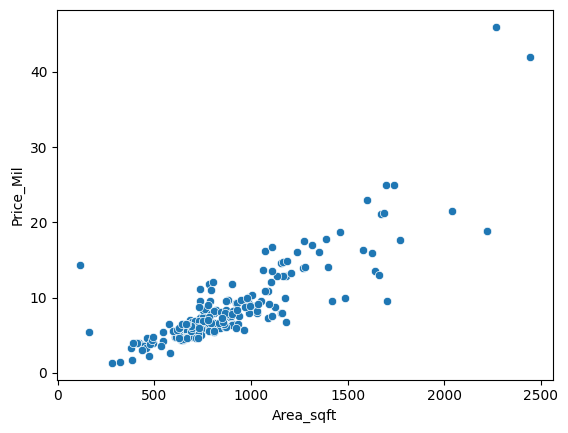

In [9]:
# Check the distribution of data and identify outliers
sns.scatterplot(data=clean_df, x="Area_sqft", y="Price_Mil")

#### Clean the rest of strings: make the data to lowercase and strip extra spaces

In [6]:
clean_df = clean_df.apply(lambda x:x.str.lower() if x.dtypes == "O" else x)
clean_df = clean_df.apply(lambda x:x.str.strip() if x.dtypes == "O" else x)

### Generate a new ordinal feature No_of_Bedroom

- Clean the string "Type" and obtain the bedroom count.
- Handle the duplex scenarios by adding the different floor's bedrooms

In [22]:
def get_bedroom_size(prop_type):
    if "bhk" in str(prop_type):
        s = [float(s) for s in re.findall(r'-?\d+\.?\d*', prop_type)]
        if len(s) == 0:
            return np.NAN
        else:
            return np.round(sum(s), 1)
    return np.NAN

clean_df["No_of_Bedroom"] = clean_df["Type"].apply(lambda x:get_bedroom_size(x))
clean_df["No_of_Bedroom"].fillna(value=np.round(clean_df["No_of_Bedroom"].mean()), inplace=True)
# Shop value got assigned the mean value as nan 

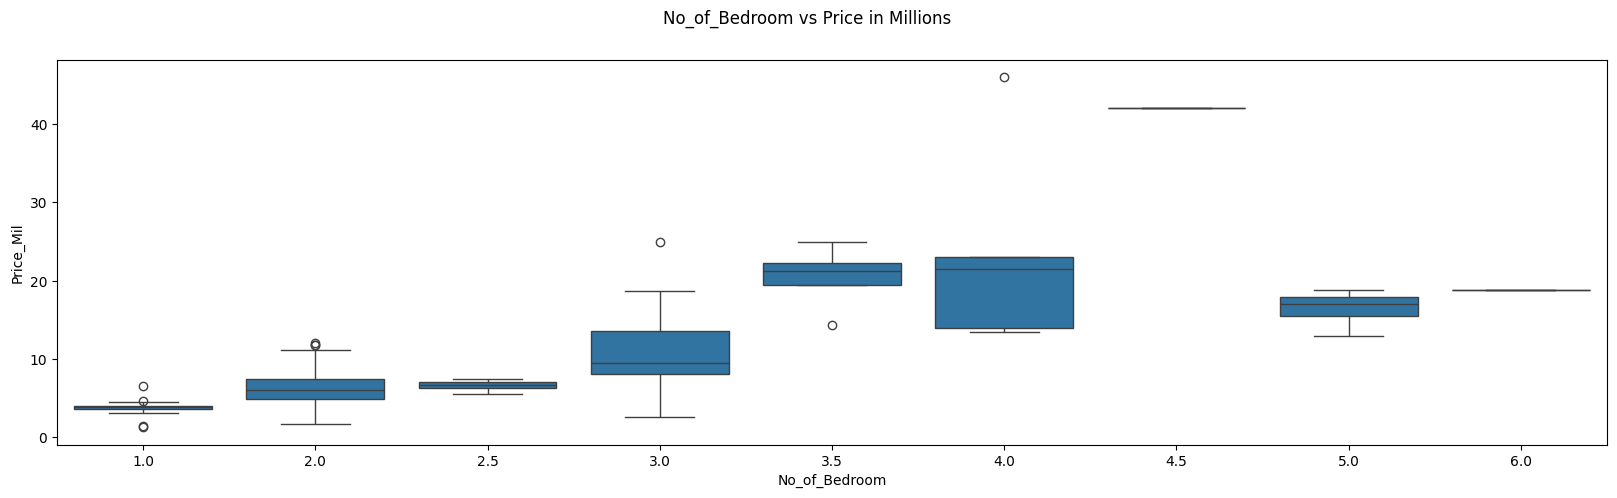

In [23]:
# Check the distribution of data and identify outliers
fig, ax = plt.subplots(figsize=(20, 5))
fig.suptitle("No_of_Bedroom vs Price in Millions")
ax.set_xlabel("No_of_Bedroom")
sns.boxplot(x ='No_of_Bedroom', y ='Price_Mil', data = clean_df,  ax=ax)
plt.show()

### Generate a new ordinal feature Township_Size

- Based on the township area, it can be classified in different sizes.
- These size categories can either be used as it is or be converted to a ordinal values using a map.
- Both the above implementations are shown below

In [24]:
def get_township_size(ts_area):

    if not np.isnan(ts_area):
        if 0 < int(ts_area) <= 25:
            return "small"
        elif 25 < int(ts_area) <= 250:
            return "medium"
        elif 250 < int(ts_area) < 25000:
            return "large"
    return "unknown"
    
ts_size_map = {
    "unknown" : 0,
    "small" : 1,
    "medium":2,
    "large":3
}

clean_df["Township_Size_Ordinal"] = clean_df["Area_township"].apply(lambda x:get_township_size(x)).map(ts_size_map).fillna(0)

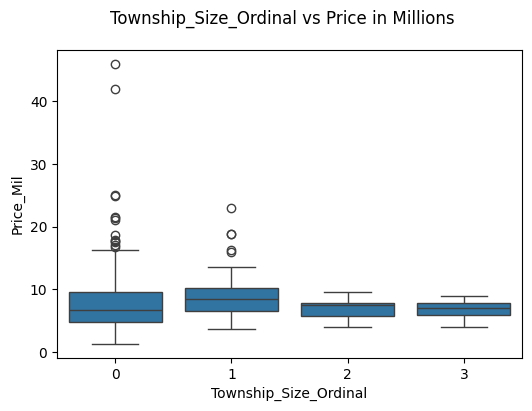

In [28]:
# Check the distribution of data and identify outliers
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Township_Size_Ordinal vs Price in Millions")
ax.set_xlabel("Township_Size_Ordinal")
sns.boxplot(x ='Township_Size_Ordinal', y ='Price_Mil', data = clean_df,  ax=ax)
plt.show()

### Generate a new set of features from Location

#### Location provides a lot of metadata and can be used to create various categorical and continuous features with lower cardinality.

Based on the data sourced from 99acres.com, I aim to create 2 distinct features:

1. __Loc_trend__ :  
    - The price trend of the location over the past N years expressed in percentages.
    - For simplicity, I've considered past 1 years YoY growth in % (decline if negative).

2. __Loc_tag__ :
    - This is the tag that identifies given location according to affordibility.
    - Basic categorie include: affordable, midrange, premium
    - This feature then can be mapped to ordinal value using a map.

In [30]:
# -100 : Highly decreasing rates over past 1 year (-100%)
# 0 : stable rates over past 1 year
# +100 : Highly increasing rates over past 1 year (+100%)
loc_trend_map = {"bavdhan" : 6.5 , "mahalunge" : 15.2 , "balewadi" :  8.3 , "ravet" : 3.6  , "baner" : 14.7  , "kharadi" :  11.5 , "koregaon park" :  13.7 , "keshav nagar" :  -2.4 , 
        "kirkatwadi sinhagad road" :  2.4 , "akurdi" :  -0.7 , "tathawade" : 4.0  , "hadapsar" :  25.2 , "kiwale" : 5.7  , "kalyani nagar" : 24.5  , "pisoli" :  -4.0 , "manjri" : 0.0  ,
        "handewadi" : 2.1  , "mundhwa" : 0.0  , "nibm" : 1.0  , "bt kawade rd" : 3.6  , "undri" : 2.5  , "karvenagar" : 2.0  , "magarpatta" : 12.1  , "hinjewadi" : 8.0  , "vimannagar" : 17.0  , 
        "wadgaon sheri" : 38.4  , "susgaon" : 3.1  , "mohammadwadi" : 4.3  , "dhanori" : 4.3  , "lonavala" : 0  , "talegoan" : 0 }
clean_df["Loc_trend"] = clean_df.Location.map(loc_trend_map).fillna(0)
# This creates continuous valued feature Loc_trend which gives overall idea of the area's price trends

<Axes: xlabel='Loc_trend', ylabel='Price_Mil'>

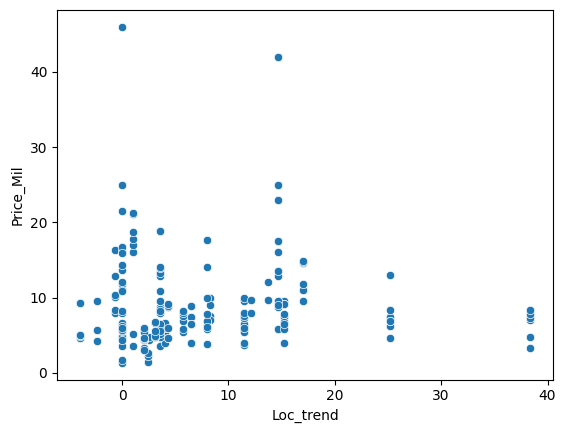

In [31]:
# Check the distribution of data and identify outliers
sns.scatterplot(data=clean_df, x="Loc_trend", y="Price_Mil")

In [32]:
# Location tag map
loc_tag_map = {}
val_tag_map = {0    : "unknown",
           1    : "affordable",
           2    : "midrange",
           3    : "premium"
        }

# Source : 99acres.com
area_idx_dict = {"bavdhan" : 3 , "mahalunge" : 3 , "balewadi" :  3 , "ravet" : 1  , "baner" : 3  , "kharadi" :  3 , "koregaon park" :  3 , "keshav nagar" :  2 , 
        "kirkatwadi sinhagad road" :  1 , "akurdi" :  2 , "tathawade" : 2  , "hadapsar" :  3 , "kiwale" : 1  , "kalyani nagar" : 3  , "pisoli" :  1 , "manjri" : 2  ,
        "handewadi" : 1  , "mundhwa" : 2  , "nibm" : 3  , "bt kawade rd" : 2  , "undri" : 2  , "karvenagar" : 3  , "magarpatta" : 3  , "hinjewadi" : 2  , "vimannagar" : 3  , 
        "wadgaon sheri" : 3  , "susgaon" : 2  , "mohammadwadi" : 3  , "dhanori" : 2  , "lonavala" : 0  , "talegoan" : 0 }

for key,val in area_idx_dict.items():
        loc_tag_map[key] = val_tag_map[val]
print(loc_tag_map)
clean_df["Loc_tag"] = clean_df.Location.map(loc_tag_map).fillna("unknown")
clean_df["Loc_tag_ordinal"] = clean_df.Location.map(area_idx_dict).fillna(0)
clean_df.head()
# This creates ordinal feature column loc_tag which can then be transformed as per required ranking

{'bavdhan': 'premium', 'mahalunge': 'premium', 'balewadi': 'premium', 'ravet': 'affordable', 'baner': 'premium', 'kharadi': 'premium', 'koregaon park': 'premium', 'keshav nagar': 'midrange', 'kirkatwadi sinhagad road': 'affordable', 'akurdi': 'midrange', 'tathawade': 'midrange', 'hadapsar': 'premium', 'kiwale': 'affordable', 'kalyani nagar': 'premium', 'pisoli': 'affordable', 'manjri': 'midrange', 'handewadi': 'affordable', 'mundhwa': 'midrange', 'nibm': 'premium', 'bt kawade rd': 'midrange', 'undri': 'midrange', 'karvenagar': 'premium', 'magarpatta': 'premium', 'hinjewadi': 'midrange', 'vimannagar': 'premium', 'wadgaon sheri': 'premium', 'susgaon': 'midrange', 'mohammadwadi': 'premium', 'dhanori': 'midrange', 'lonavala': 'unknown', 'talegoan': 'unknown'}


,Location,Type,Area_sqft,Price_Lakhs,Price_Mil,Developer,Name,Area_township,hasClubHouse,hasEduFacility,hasHospital,hasMall,hasParkOrJogTrack,hasPool,hasGym,No_of_Bedroom,Township_Size_Ordinal,Loc_trend,Loc_tag,Loc_tag_ordinal
0,bavdhan,1 bhk,492.0,NaN,3.9,shapoorji paloonji,vanaha,1000.0,yes,yes,yes,yes,yes,yes,yes,1.0,3,6.5,premium,3.0
1,bavdhan,2 bhk,774.0,NaN,6.5,shapoorji paloonji,vanaha,1000.0,yes,yes,yes,yes,yes,yes,yes,2.0,3,6.5,premium,3.0
2,bavdhan,3 bhk,889.0,NaN,7.4,shapoorji paloonji,vanaha,1000.0,yes,yes,yes,yes,yes,yes,yes,3.0,3,6.5,premium,3.0
3,bavdhan,3 bhk grand,1018.0,NaN,8.9,shapoorji paloonji,vanaha,1000.0,yes,yes,yes,yes,yes,yes,yes,3.0,3,6.5,premium,3.0
4,mahalunge,2bhk,743.0,NaN,7.4,godrej properties,godrej hills retreat,100.0,yes,yes,yes,yes,yes,yes,yes,2.0,2,15.2,premium,3.0


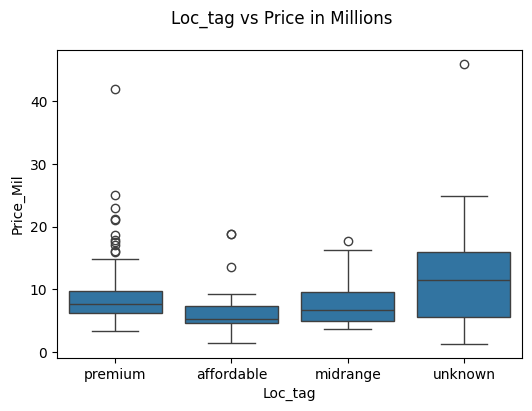

In [35]:
# Check the distribution of data and identify outliers
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Loc_tag vs Price in Millions")
ax.set_xlabel("Loc_tag")
sns.boxplot(x ='Loc_tag', y ='Price_Mil', data = clean_df,  ax=ax)
plt.show()

### Generate One-hot encodings for boolean features using pandas

In [36]:
dummy_cat = pd.get_dummies(clean_df[["hasClubHouse","hasEduFacility",	"hasHospital",	"hasMall",	"hasParkOrJogTrack",	"hasPool",	"hasGym"]], drop_first=True, dtype=int)
clean_df = pd.concat([clean_df, dummy_cat], axis=1)

In [37]:
clean_df = clean_df.drop(["Area_township","Type", "Price_Lakhs", "Loc_tag", "hasClubHouse","hasEduFacility",	"hasHospital",	"hasMall",	"hasParkOrJogTrack",	"hasPool",	"hasGym"], axis=1)
print("Final cleaned Dataframe:")
clean_df.head()

Final cleaned Dataframe:


,Location,Area_sqft,Price_Mil,Developer,Name,No_of_Bedroom,Township_Size_Ordinal,Loc_trend,Loc_tag_ordinal,hasClubHouse_yes,hasEduFacility_yes,hasHospital_yes,hasMall_yes,hasParkOrJogTrack_yes,hasPool_yes,hasGym_yes
0,bavdhan,492.0,3.9,shapoorji paloonji,vanaha,1.0,3,6.5,3.0,1,1,1,1,1,1,1
1,bavdhan,774.0,6.5,shapoorji paloonji,vanaha,2.0,3,6.5,3.0,1,1,1,1,1,1,1
2,bavdhan,889.0,7.4,shapoorji paloonji,vanaha,3.0,3,6.5,3.0,1,1,1,1,1,1,1
3,bavdhan,1018.0,8.9,shapoorji paloonji,vanaha,3.0,3,6.5,3.0,1,1,1,1,1,1,1
4,mahalunge,743.0,7.4,godrej properties,godrej hills retreat,2.0,2,15.2,3.0,1,1,1,1,1,1,1


In [38]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               200 non-null    object 
 1   Area_sqft              200 non-null    float64
 2   Price_Mil              200 non-null    float64
 3   Developer              200 non-null    object 
 4   Name                   200 non-null    object 
 5   No_of_Bedroom          200 non-null    float64
 6   Township_Size_Ordinal  200 non-null    int64  
 7   Loc_trend              200 non-null    float64
 8   Loc_tag_ordinal        200 non-null    float64
 9   hasClubHouse_yes       200 non-null    int32  
 10  hasEduFacility_yes     200 non-null    int32  
 11  hasHospital_yes        200 non-null    int32  
 12  hasMall_yes            200 non-null    int32  
 13  hasParkOrJogTrack_yes  200 non-null    int32  
 14  hasPool_yes            200 non-null    int32  
 15  hasGym


Correlation Matrix for scaled data:


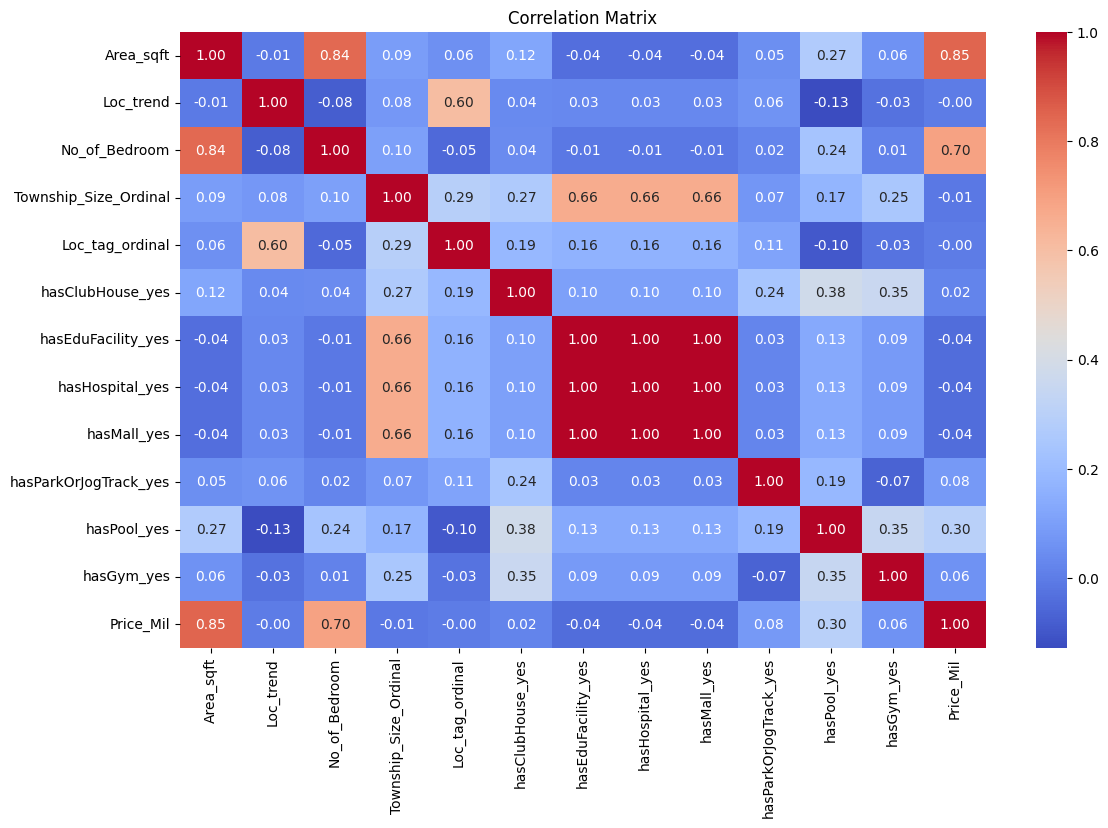

In [40]:
encoded_feat = ["Area_sqft", "Loc_trend", 
                "No_of_Bedroom", "Township_Size_Ordinal", "Loc_tag_ordinal",
                "hasClubHouse_yes","hasEduFacility_yes",	"hasHospital_yes",	"hasMall_yes",	"hasParkOrJogTrack_yes",	"hasPool_yes",	"hasGym_yes", 
                "Price_Mil"]
correlation_matrix = clean_df[encoded_feat].corr(method='pearson')

print("\nCorrelation Matrix for scaled data:")
#print(correlation_matrix)

plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## The above correlation matrix shows what features can be dropped on the basis of low correlation and multicolinearity between features.

For demonstration purposes, I've not dropped these, but in the future models can be trained on a subset of features.  

## Encoding Location, Developer, and Name features

- Ideally, these features can be encoded using text-embeddings for better understanding of the actual name.
- However, it is compute-intensive and may take a lot of efforts for non-significant improvement for this toy data.
- Thus, Target encoding with mean Price can be considered as a suitable type of category encoder.

In [41]:
# Split the data in train and test sets to avoid data leakage during scaling and encoding.

y = clean_df["Price_Mil"]
X = clean_df.drop(["Price_Mil"], axis=1)

test_ratio = 0.2
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_ratio, random_state=random_seed)

In [42]:
full_train_df = pd.concat([X_train, y_train], axis=1)
full_test_df = pd.concat([X_test, y_test], axis=1)
print("Train data shape: ", full_train_df.shape)
print("Test data shape: ", full_test_df.shape)

Train data shape:  (160, 16)
Test data shape:  (40, 16)


#### Target encoder for 3 categorical features

In [43]:
#Target encoding cate feats
cat_feat = ["Location", "Developer", "Name"]

# Define encoder
tgt_encoder = TargetEncoder(target_type="continuous")

# Fit and transform the training data
full_train_df[cat_feat] = tgt_encoder.fit_transform(full_train_df[cat_feat], full_train_df["Price_Mil"])

# Transform on test data, for unseen data a mean of group can be assigned
full_test_df[cat_feat] = tgt_encoder.transform(full_test_df[cat_feat])

### Scale/Normalize the continuous data 

In [44]:
num_feat = cat_feat + ["Area_sqft","Loc_trend"]
print(num_feat)

['Location', 'Developer', 'Name', 'Area_sqft', 'Loc_trend']


In [45]:
# Scaling Numerical features
train_scalar = StandardScaler()
full_train_df[num_feat] = train_scalar.fit_transform(full_train_df[num_feat])
full_train_df.describe()

,Location,Area_sqft,Developer,Name,No_of_Bedroom,Township_Size_Ordinal,Loc_trend,Loc_tag_ordinal,hasClubHouse_yes,hasEduFacility_yes,hasHospital_yes,hasMall_yes,hasParkOrJogTrack_yes,hasPool_yes,hasGym_yes,Price_Mil
count,1.600000e+02,1.600000e+02,1.600000e+02,1.600000e+02,160.000000,160.000000,1.600000e+02,160.000000,160.000000,160.00000,160.00000,160.00000,160.000000,160.000000,160.000000,160.000000
mean,1.665335e-17,1.110223e-17,4.107825e-16,5.551115e-17,2.412500,0.350000,-3.330669e-17,2.087500,0.725000,0.03750,0.03750,0.03750,0.987500,0.612500,0.806250,8.539006
std,1.003140e+00,1.003140e+00,1.003140e+00,1.003140e+00,0.834684,0.646228,1.003140e+00,1.005566,0.447916,0.19058,0.19058,0.19058,0.111451,0.488709,0.396476,5.182403
min,-2.107245e+00,-2.083066e+00,-2.437428e+00,-1.550032e+00,1.000000,0.000000,-1.256738e+00,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,1.319000
25%,-5.987881e-01,-5.919538e-01,-7.536157e-01,-5.471386e-01,2.000000,0.000000,-7.193835e-01,1.000000,0.000000,0.00000,0.00000,0.00000,1.000000,0.000000,1.000000,5.175000
50%,-1.580457e-01,-2.340069e-01,-1.469778e-01,-2.264465e-01,2.000000,0.000000,-3.808501e-01,2.000000,1.000000,0.00000,0.00000,0.00000,1.000000,1.000000,1.000000,7.125000
75%,3.630076e-01,3.919002e-01,3.411828e-01,2.379895e-01,3.000000,1.000000,4.090612e-01,3.000000,1.000000,0.00000,0.00000,0.00000,1.000000,1.000000,1.000000,9.746750
max,4.045854e+00,4.140011e+00,3.008100e+00,7.196682e+00,6.000000,3.000000,3.300029e+00,3.000000,1.000000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,42.000000


In [47]:
full_test_df[num_feat] = train_scalar.transform(full_test_df[num_feat])
full_test_df.describe()

,Location,Area_sqft,Developer,Name,No_of_Bedroom,Township_Size_Ordinal,Loc_trend,Loc_tag_ordinal,hasClubHouse_yes,hasEduFacility_yes,hasHospital_yes,hasMall_yes,hasParkOrJogTrack_yes,hasPool_yes,hasGym_yes,Price_Mil
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.0,40.0,40.000000,40.000000,40.000000,40.000000
mean,0.010935,-0.002741,0.072311,0.005348,2.312500,0.200000,0.029958,1.900000,0.800000,0.0,0.0,0.0,0.950000,0.725000,0.825000,9.303225
std,0.819407,1.068877,1.027013,0.846499,0.882069,0.516398,1.069873,1.057331,0.405096,0.0,0.0,0.0,0.220721,0.452203,0.384808,7.679335
min,-1.154647,-1.296516,-1.266332,-0.850183,1.000000,0.000000,-1.256738,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.350000
25%,-0.547235,-0.601286,-0.700922,-0.599505,2.000000,0.000000,-0.719384,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,5.249250
50%,-0.122941,-0.275334,-0.181798,-0.300193,2.000000,0.000000,-0.418465,2.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,7.070500
75%,0.390534,0.404565,0.279836,0.330516,3.000000,0.000000,0.495038,3.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,8.975000
max,1.765119,3.660082,2.028346,2.282639,5.000000,2.000000,3.300029,3.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,46.000000


#### Save the encoders, scalars and final datasets

In [48]:
pickle.dump(train_scalar, open('../data/processed/artifacts/train_scaler.pkl', 'wb'))
pickle.dump(tgt_encoder, open('../data/processed/artifacts/tgt_encoder.pkl', 'wb'))

full_train_df.to_csv("../data/processed/data/train-v1.csv", index=False)
full_test_df.to_csv("../data/processed/data/test-v1.csv", index=False)

## At this point the training and testing data is ready for model experimentation (detailed in 03_model_research.ipynb)

#### __Thanks__